## Houston Machine Learning Meet Up
### Neilkunal Panchal
#### Saturday 12th October 2019
### Multi Agent Reinforcement Learning for Glide Hockey

# 1.0 Import Dependencies and Load Environments
mlagents, numpy and pytorch

In [1]:
import torch
import numpy as np
from mlagents.envs.environment import UnityEnvironment
from ddpg_agent import Agents
import matplotlib.pyplot as plt
from collections import deque

- Load the 'AirHockey' environment be sure to chose the folder path to where the App is build
- Diplay information about the number of Brains, Agents, states and actions

In [2]:
# env = UnityEnvironment(file_name = "/Users/neil_panchal/Desktop/AirHockey.app", worker_id=1)
env = UnityEnvironment(file_name = 'AirHockey.app', worker_id=13)
default_brain = env.brain_names[0]
brain = env.brains[default_brain]

INFO:mlagents.envs:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 2
        Number of Training Brains : 1
        Reset Parameters :
		scale -> 1.0
		gravity -> 9.8100004196167
Unity brain name: HockeyBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): [2]
        Vector Action descriptions: , 
Unity brain name: HockeyPlayer
        Number of Visual Observations (per agent): 0
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): [2]
        Vector Action descriptions: left, right


- Test resetting the environment 

In [3]:
train_mode = True
# Reset the environment
env_info = env.reset(train_mode=train_mode)[default_brain]
env_info.vector_observations

array([[  0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          3.38993621,   0.        ,  -0.        ,   0.        ,
         -0.        ,   0.        , -20.        ,   1.        ],
       [  0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          2.70024681,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,  20.        ,   1.        ]])

In [4]:
# Examine the state space for the default brain
print("Agent state looks like: \n{}".format(env_info.vector_observations[0]))

# Examine the observation space for the default brain
for observation in env_info.visual_observations:
    print("Agent observations look like:")
    if observation.shape[3] == 3:
        plt.imshow(observation[0,:,:,:])
    else:
        plt.imshow(observation[0,:,:,0])

Agent state looks like: 
[  0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           3.38993621   0.          -0.           0.
  -0.           0.         -20.           1.        ]


In [5]:
print(env_info.rewards)
print(brain.vector_action_space_type)
env_info.vector_observations

[0.0, 0.0]
continuous


array([[  0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          3.38993621,   0.        ,  -0.        ,   0.        ,
         -0.        ,   0.        , -20.        ,   1.        ],
       [  0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          2.70024681,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,  20.        ,   1.        ]])

# 2.0 Test Envionment with Random Actions

In [6]:
for episode in range(100):
    env_info = env.reset(train_mode=train_mode)[default_brain]
    done = False
    episode_rewards = 0
    while not done:
        action_size = brain.vector_action_space_size
        if brain.vector_action_space_type == 'continuous':
            env_info = env.step(np.random.randn(len(env_info.agents), 
                                                action_size[0]))[default_brain]
        else:
            action = np.column_stack([np.random.randint(0, action_size[i], size=(len(env_info.agents))) for i in range(len(action_size))])
            env_info = env.step(action)[default_brain]
        episode_rewards += env_info.rewards[0]
        done = env_info.local_done[0]
    print("Total reward this episode: {}".format(episode_rewards))

Total reward this episode: -0.710000041872263
Total reward this episode: -5.0100003546103835
Total reward this episode: -2.6400001933798194
Total reward this episode: -5.0100003546103835
Total reward this episode: -3.1560002407059073
Total reward this episode: -0.12900003232061863
Total reward this episode: -0.09000001195818186
Total reward this episode: -0.08600002340972424
Total reward this episode: -0.9900000691413879
Total reward this episode: -1.5800001258030534
Total reward this episode: -0.06800002604722977
Total reward this episode: -0.051000011153519154
Total reward this episode: 0.015999987721443176
Total reward this episode: -0.10900003090500832
Total reward this episode: -0.10900003090500832
Total reward this episode: -1.280000097118318
Total reward this episode: -0.13600002694875002
Total reward this episode: -0.640000051818788
Total reward this episode: -0.049000026658177376
Total reward this episode: -1.7700001318007708
Total reward this episode: -0.08200001530349255
Tot

# 3.0 Train the Agents
- Agents: is the class for the agents. This is instantiated for 2 players
- get_actions: returns the concatenated actions for both players in the form of a Markov Game and adds noise to encourage exploration
- maddpg: is the multi-agent-deep-deterministic policy gradient traning method
    - hyper parameters are: number of episodes
    - OU noise for Policy Gradient
    - max number of time steps
    - reward required to solve the environment
    - test: loads the trained weights of a NN and plays this against the environment


In [7]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

In [8]:
brain
#reset the environment
env_info = env.reset(train_mode=True)[brain_name]

In [9]:
#

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
print('States is:', states)
state_size = np.shape(states[1])
print(state_size)
# state_size=8
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: [2]
States is: [[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   3.32697582e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00
  -2.71592617e+00  1.94946098e+00  1.05776620e+00  8.94069672e-08]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   3.06033611e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   2.71592617e+00  1.94946098e+00 -1.05776620e+00  8.94069672e-08]]
(24,)
There are 2 agents. Each observes a state with length: (24,)
The state for the first agent looks like: [ 0.00000000e+00  0.00000000e+00  0.0000

In [10]:
action_size[0]

2

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
print((device is  "cuda:0"))

cpu
False


In [12]:
# env_info = env.reset(train_mode=train_mode)[brain_name] 
# actions = get_actions(states, addNoise)           
# env_info = env.step(actions)[brain_name] 
# np.shape(env_info.vector_observations)

In [13]:

# num_agents=1
# agent = Agents(state_size=state_size, action_size=action_size, num_agents=num_agents, random_seed=0)
# agent.action_size
print('state size is:', state_size[0])
print('action size is :', action_size[0])
agent_0 = Agents(state_size=state_size[0], action_size=action_size[0], num_agents=1, random_seed=0)
agent_1 = Agents(state_size=state_size[0], action_size=action_size[0], num_agents=1, random_seed=0)

state size is: 24
action size is : 2
on init device is: cpu
False
action size is:  2
action size is:  2
on init device is: cpu
False
action size is:  2
action size is:  2


In [14]:
def get_actions(states, add_noise):
    '''gets actions for each agent and then combines them into one array'''
    action_0 = agent_0.act(states, add_noise)    
    action_1 = agent_1.act(states, add_noise)   
    return np.concatenate((action_0, action_1), axis=0).flatten()

In [15]:
solved = 1
consecutiveEpisodes = 10
printFrequency = 1
addNoise = True

def Maddpg(n_episodes=20, max_t=1000, train_mode=True):
    """Multi-Agent Deep Deterministic Policy Gradient (MADDPG)
    
    Params
    ======
        n_episodes (int)      : maximum number of training episodes
        max_t (int)           : maximum number of timesteps per episode
        train_mode (bool)     : if 'True' set environment to training mode

    """
    scores_window = deque(maxlen=consecutiveEpisodes)
    scores_all = []
    moving_average = []
    best_score = -np.inf
    best_episode = 0
    already_solved = False    

    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=train_mode)[brain_name]  
        states = np.reshape(env_info.vector_observations, (1,48)) # combine states
        agent_0.reset()
        agent_1.reset()
        scores = np.zeros(num_agents)
        while True:
            actions = get_actions(states, addNoise)           
            env_info = env.step(actions)[brain_name] 
#             print('shape of observations is', np.shape(env_info.vector_observations))
#             print('observations are', env_info.vector_observations)
#             print('actions', actions)
            next_states = np.reshape(env_info.vector_observations, (1, 48)) # combine the agent next states
            rewards = env_info.rewards                         # get reward        
            done = env_info.local_done                         # see if episode finished
            agent_0.step(states, actions, rewards[0], next_states, done, 0) # agent 1 learning
            agent_1.step(states, actions, rewards[1], next_states, done, 1) # agent 2 learning
            scores += np.max(rewards)                          # update the score for each agent
            states = next_states                              
            if np.any(done):                                   # exit loop if episode finished
                break

        ep_best_score = np.max(scores)
        scores_window.append(ep_best_score)
        scores_all.append(ep_best_score)
        moving_average.append(np.mean(scores_window))

        # save best score                        
        if ep_best_score > best_score:
            best_score = ep_best_score
            best_episode = i_episode
        
        # print results
        if i_episode % printFrequency == 0:
            print('Episodes {:0>4d}-{:0>4d}\tMax Reward: {:.3f}\tMoving Average: {:.3f}'.format(
                i_episode-printFrequency, i_episode, np.max(scores_all[-printFrequency:]), moving_average[-1]))

        # determine if environment is solved and keep best performing models
        if moving_average[-1] >= solved:
            if not already_solved:
                print('<-- Environment solved in {:d} episodes! \
                \n<-- Moving Average: {:.3f} over past {:d} episodes'.format(
                    i_episode-consecutiveEpisodes, moving_average[-1], consecutiveEpisodes))
                already_solved = True
                # save weights
                torch.save(agent_0.actor_local.state_dict(), 'checkpoint_actor_0.pth')
                torch.save(agent_0.critic_local.state_dict(), 'checkpoint_critic_0.pth')
                torch.save(agent_1.actor_local.state_dict(), 'checkpoint_actor_1.pth')
                torch.save(agent_1.critic_local.state_dict(), 'checkpoint_critic_1.pth')
            elif ep_best_score >= best_score:
                print('<-- Best episode so far!\
                \nEpisode {:0>4d}\tMax Reward: {:.3f}\tMoving Average: {:.3f}'.format(
                i_episode, ep_best_score, moving_average[-1]))
                # save weights
                torch.save(agent_0.actor_local.state_dict(), 'checkpoint_actor_0.pth')
                torch.save(agent_0.critic_local.state_dict(), 'checkpoint_critic_0.pth')
                torch.save(agent_1.actor_local.state_dict(), 'checkpoint_actor_1.pth')
                torch.save(agent_1.critic_local.state_dict(), 'checkpoint_critic_1.pth')
            elif (i_episode-best_episode) >= 100:
                # stop training if model stops converging
                print('<-- Training stopped. Best score not matched or exceeded for 200 episodes')
                break
            else:
                continue
            
    return scores_all, moving_average

Episodes 0000-0001	Max Reward: -0.295	Moving Average: -0.295
Episodes 0001-0002	Max Reward: -0.107	Moving Average: -0.201


/Users/neil_panchal/Desktop/ddpg_agent.py:139: UserWarning: Using a target size (torch.Size([128, 2])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  critic_loss = F.mse_loss(Q_expected, Q_targets)


Episodes 0002-0003	Max Reward: -1.290	Moving Average: -0.564
Episodes 0003-0004	Max Reward: -1.715	Moving Average: -0.852
Episodes 0004-0005	Max Reward: -2.708	Moving Average: -1.223
Episodes 0005-0006	Max Reward: -1.808	Moving Average: -1.321
Episodes 0006-0007	Max Reward: -0.526	Moving Average: -1.207
Episodes 0007-0008	Max Reward: 0.012	Moving Average: -1.055
Episodes 0008-0009	Max Reward: -0.054	Moving Average: -0.943
Episodes 0009-0010	Max Reward: -3.570	Moving Average: -1.206
Episodes 0010-0011	Max Reward: -1.049	Moving Average: -1.282
Episodes 0011-0012	Max Reward: 0.020	Moving Average: -1.269
Episodes 0012-0013	Max Reward: -2.544	Moving Average: -1.394
Episodes 0013-0014	Max Reward: -1.724	Moving Average: -1.395
Episodes 0014-0015	Max Reward: -1.601	Moving Average: -1.284
Episodes 0015-0016	Max Reward: -0.033	Moving Average: -1.107
Episodes 0016-0017	Max Reward: 0.021	Moving Average: -1.052
Episodes 0017-0018	Max Reward: -2.378	Moving Average: -1.291
Episodes 0018-0019	Max Rewa

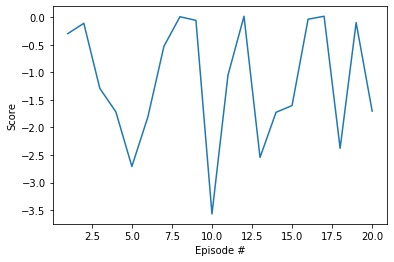

In [16]:
scores, averages = Maddpg()

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [17]:
CONSEC_EPISODES = 10
PRINT_EVERY = 1
addNoise = False

In [18]:
## reinitialize the agents (if needed)
agent_0 = Agents(state_size[0], action_size[0], num_agents=1, random_seed=0)
agent_1 = Agents(state_size[0], action_size[0], num_agents=1, random_seed=0)

# load the weights from file
agent_0_weights = 'checkpoint_actor_0.pth'
agent_1_weights = 'checkpoint_actor_1.pth'
agent_0.actor_local.load_state_dict(torch.load(agent_0_weights))
agent_1.actor_local.load_state_dict(torch.load(agent_1_weights))

on init device is: cpu
False
action size is:  2
action size is:  2
on init device is: cpu
False
action size is:  2
action size is:  2


<All keys matched successfully>

In [19]:
def test(n_episodes=10, max_t=1000, train_mode=False):

    scores_window = deque(maxlen=consecutiveEpisodes)
    scores_all = []
    moving_average = []  

    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=train_mode)[brain_name]         # reset the environment
        states = np.reshape(env_info.vector_observations, (1,48)) # get states and combine them
        scores = np.zeros(num_agents)
        while True:
            actions = get_actions(states, addNoise)           # choose agent actions and combine them
            env_info = env.step(actions)[brain_name]           # send both agents' actions together to the environment
            next_states = np.reshape(env_info.vector_observations, (1, 48)) # combine the agent next states
            rewards = env_info.rewards                         # get reward
            done = env_info.local_done                         # see if episode finished
            scores += np.max(rewards)                          # update the score for each agent
            states = next_states                               # roll over states to next time step
            if np.any(done):                                   # exit loop if episode finished
                break

        ep_best_score = np.max(scores)
        scores_window.append(ep_best_score)
        scores_all.append(ep_best_score)
        moving_average.append(np.mean(scores_window))

        # print results
        if i_episode % printFrequency == 0:
            print('Episodes {:0>4d}-{:0>4d}\tMax Reward: {:.3f}\tMoving Average: {:.3f}'.format(
                i_episode-printFrequency, i_episode, np.max(scores_all[-PRINT_EVERY:]), moving_average[-1]))
            
    return scores_all, moving_average
test()



Episodes 0000-0001	Max Reward: -0.155	Moving Average: -0.155
Episodes 0001-0002	Max Reward: -0.119	Moving Average: -0.137
Episodes 0002-0003	Max Reward: -5.010	Moving Average: -1.761
Episodes 0003-0004	Max Reward: -5.010	Moving Average: -2.574
Episodes 0004-0005	Max Reward: -5.010	Moving Average: -3.061
Episodes 0005-0006	Max Reward: -5.010	Moving Average: -3.386
Episodes 0006-0007	Max Reward: -5.010	Moving Average: -3.618
Episodes 0007-0008	Max Reward: -5.010	Moving Average: -3.792
Episodes 0008-0009	Max Reward: -5.010	Moving Average: -3.927
Episodes 0009-0010	Max Reward: -2.082	Moving Average: -3.743


([-0.1550000263378024,
  -0.11900003161281347,
  -5.0100003546103835,
  -5.0100003546103835,
  -5.0100003546103835,
  -5.0100003546103835,
  -5.0100003546103835,
  -5.0100003546103835,
  -5.0100003546103835,
  -2.082000156864524],
 [-0.1550000263378024,
  -0.13700002897530794,
  -1.7613334708536665,
  -2.5735001917928457,
  -3.0608002243563535,
  -3.385666912732025,
  -3.6177145472860763,
  -3.7917502732016146,
  -3.9271113933581443,
  -3.7426002697087823])